In [1]:
!cp /content/drive/MyDrive/dog-dataset.zip ./

In [2]:
!unzip /content/dog-dataset.zip -d data-folder

Streaming output truncated to the last 5000 lines.
  inflating: data-folder/dog-breed-identification/train/6620cb2082fd57c0c56f2e4903b5339a.jpg  
  inflating: data-folder/dog-breed-identification/train/538921b32a385b9e4cd5ce4dbb0ba462.jpg  
  inflating: data-folder/dog-breed-identification/train/823d252a19df2cfc3d579952715e43b4.jpg  
  inflating: data-folder/dog-breed-identification/train/0c36c19e7c4e932b8e0c01aa845b2fce.jpg  
  inflating: data-folder/dog-breed-identification/train/0fdfc060cdbaf30f356ffb4946df4580.jpg  
  inflating: data-folder/dog-breed-identification/train/bea765154749ffbccdc2e4321027e3a8.jpg  
  inflating: data-folder/dog-breed-identification/train/726d82feb07e25afed0f2373882ff084.jpg  
  inflating: data-folder/dog-breed-identification/train/8ae1475b493ceb4dc93924ccdf1f98cd.jpg  
  inflating: data-folder/dog-breed-identification/train/1a0a76e482a7963a008e29977d48aad4.jpg  
  inflating: data-folder/dog-breed-identification/train/1831f3ce615ffe27a78c5baa362ac677.jpg  

In [3]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 9.1 MB/s 


In [4]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torchmetrics


import cv2
import random
from random import randint
import time

import torch
from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn.functional as F
import torch.nn as nn


from PIL import Image
from scipy import ndimage


import torchvision
import torchvision.models as models

from torchvision import transforms
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, Subset, DataLoader

from tqdm.notebook import tqdm


from sklearn.metrics import f1_score
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/data-folder/dog-breed-identification'

Mounted at /content/gdrive


In [6]:
TRAIN_DIR = root_path + '/train'                           
TEST_DIR = root_path + '/test'                             

TRAIN_CSV = root_path + '/labels.csv'                     
TEST_CSV = root_path + '/submission.csv'

In [7]:
data_df = pd.read_csv(TRAIN_CSV)
data_df.head(10)

id               breed
0  000bec180eb18c7604dcecc8fe0dba07         boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97               dingo
2  001cdf01b096e06d78e9e5112d419397            pekinese
3  00214f311d5d2247d5dfe4fe24b2303d            bluetick
4  0021f9ceb3235effd7fcde7f7538ed62    golden_retriever
5  002211c81b498ef88e1b40b9abf84e1d  bedlington_terrier
6  00290d3e1fdd27226ba27a8ce248ce85  bedlington_terrier
7  002a283a315af96eaea0e28e7163b21b              borzoi
8  003df8b8a8b05244b1d920bb6cf451f9             basenji
9  0042188c895a2f14ef64a918ed9c7b64  scottish_deerhound

In [8]:
labels_names=data_df["breed"].unique()
labels_sorted=labels_names.sort()

labels = dict(zip(range(len(labels_names)),labels_names))
labels

{0: 'affenpinscher',
 1: 'afghan_hound',
 2: 'african_hunting_dog',
 3: 'airedale',
 4: 'american_staffordshire_terrier',
 5: 'appenzeller',
 6: 'australian_terrier',
 7: 'basenji',
 8: 'basset',
 9: 'beagle',
 10: 'bedlington_terrier',
 11: 'bernese_mountain_dog',
 12: 'black-and-tan_coonhound',
 13: 'blenheim_spaniel',
 14: 'bloodhound',
 15: 'bluetick',
 16: 'border_collie',
 17: 'border_terrier',
 18: 'borzoi',
 19: 'boston_bull',
 20: 'bouvier_des_flandres',
 21: 'boxer',
 22: 'brabancon_griffon',
 23: 'briard',
 24: 'brittany_spaniel',
 25: 'bull_mastiff',
 26: 'cairn',
 27: 'cardigan',
 28: 'chesapeake_bay_retriever',
 29: 'chihuahua',
 30: 'chow',
 31: 'clumber',
 32: 'cocker_spaniel',
 33: 'collie',
 34: 'curly-coated_retriever',
 35: 'dandie_dinmont',
 36: 'dhole',
 37: 'dingo',
 38: 'doberman',
 39: 'english_foxhound',
 40: 'english_setter',
 41: 'english_springer',
 42: 'entlebucher',
 43: 'eskimo_dog',
 44: 'flat-coated_retriever',
 45: 'french_bulldog',
 46: 'german_sheph

In [9]:
lbl=[]
for i in range(len(data_df["breed"])):
    temp=list(labels.values()).index(data_df.breed[i])
    lbl.append(temp)

    
data_df['lbl'] = lbl
#data_df['lbl'] = data_df['lbl'].astype(str)
data_df.head(10)

id               breed  lbl
0  000bec180eb18c7604dcecc8fe0dba07         boston_bull   19
1  001513dfcb2ffafc82cccf4d8bbaba97               dingo   37
2  001cdf01b096e06d78e9e5112d419397            pekinese   85
3  00214f311d5d2247d5dfe4fe24b2303d            bluetick   15
4  0021f9ceb3235effd7fcde7f7538ed62    golden_retriever   49
5  002211c81b498ef88e1b40b9abf84e1d  bedlington_terrier   10
6  00290d3e1fdd27226ba27a8ce248ce85  bedlington_terrier   10
7  002a283a315af96eaea0e28e7163b21b              borzoi   18
8  003df8b8a8b05244b1d920bb6cf451f9             basenji    7
9  0042188c895a2f14ef64a918ed9c7b64  scottish_deerhound   97

In [10]:
path_img=[]
for i in range(len(data_df["id"])):
    temp=TRAIN_DIR + "/" + str(data_df.id[i]) + ".jpg"
    path_img.append(temp)

data_df['path_img'] =path_img
data_df.head()

id             breed  lbl  \
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull   19   
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo   37   
2  001cdf01b096e06d78e9e5112d419397          pekinese   85   
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick   15   
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever   49   

                                            path_img  
0  /content/data-folder/dog-breed-identification/...  
1  /content/data-folder/dog-breed-identification/...  
2  /content/data-folder/dog-breed-identification/...  
3  /content/data-folder/dog-breed-identification/...  
4  /content/data-folder/dog-breed-identification/...

In [11]:
num_images = len(data_df["id"])
print('Number of images in Training file:', num_images)
no_labels=len(labels_names)
print('Number of dog breeds in Training file:', no_labels)

Number of images in Training file: 10222
Number of dog breeds in Training file: 120


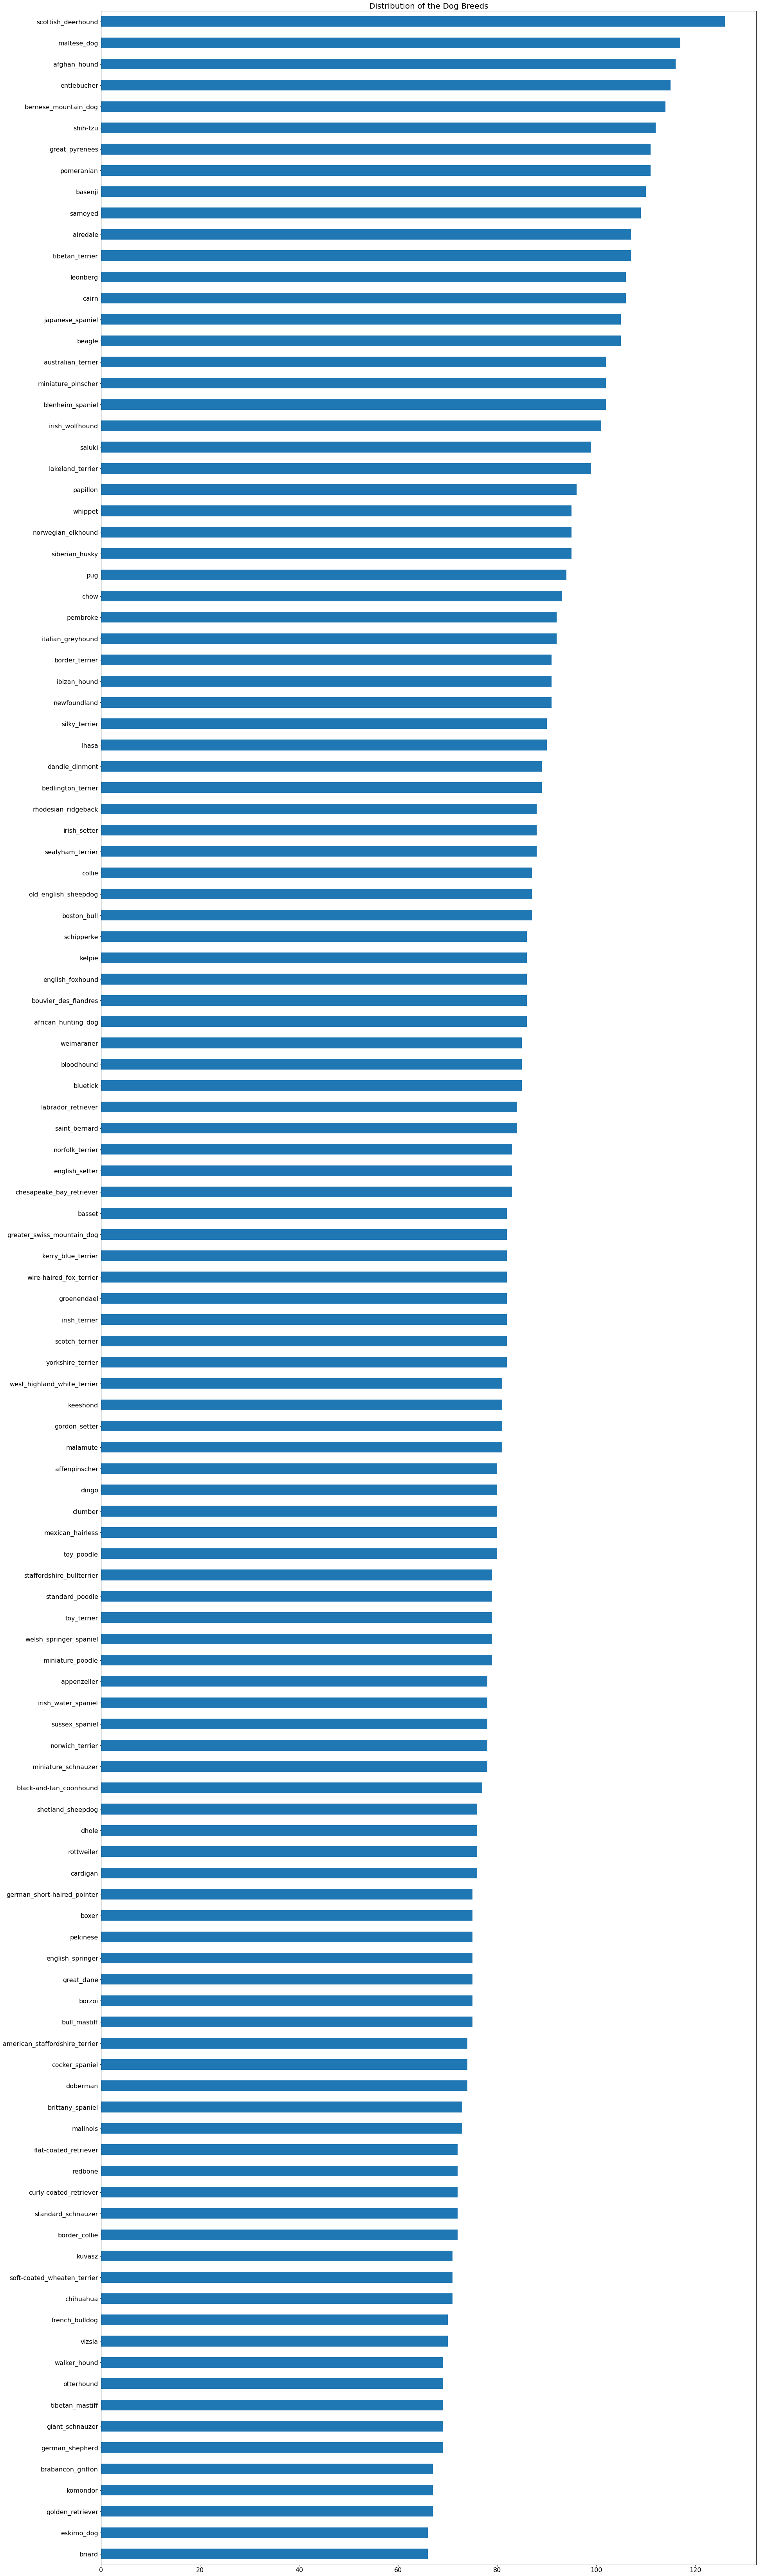

In [12]:
bar = data_df["breed"].value_counts(ascending=True).plot.barh(figsize = (30,120))
plt.title("Distribution of the Dog Breeds", fontsize = 20)
bar.tick_params(labelsize=16)
plt.show()

In [13]:
data_df["breed"].value_counts(ascending=False)

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

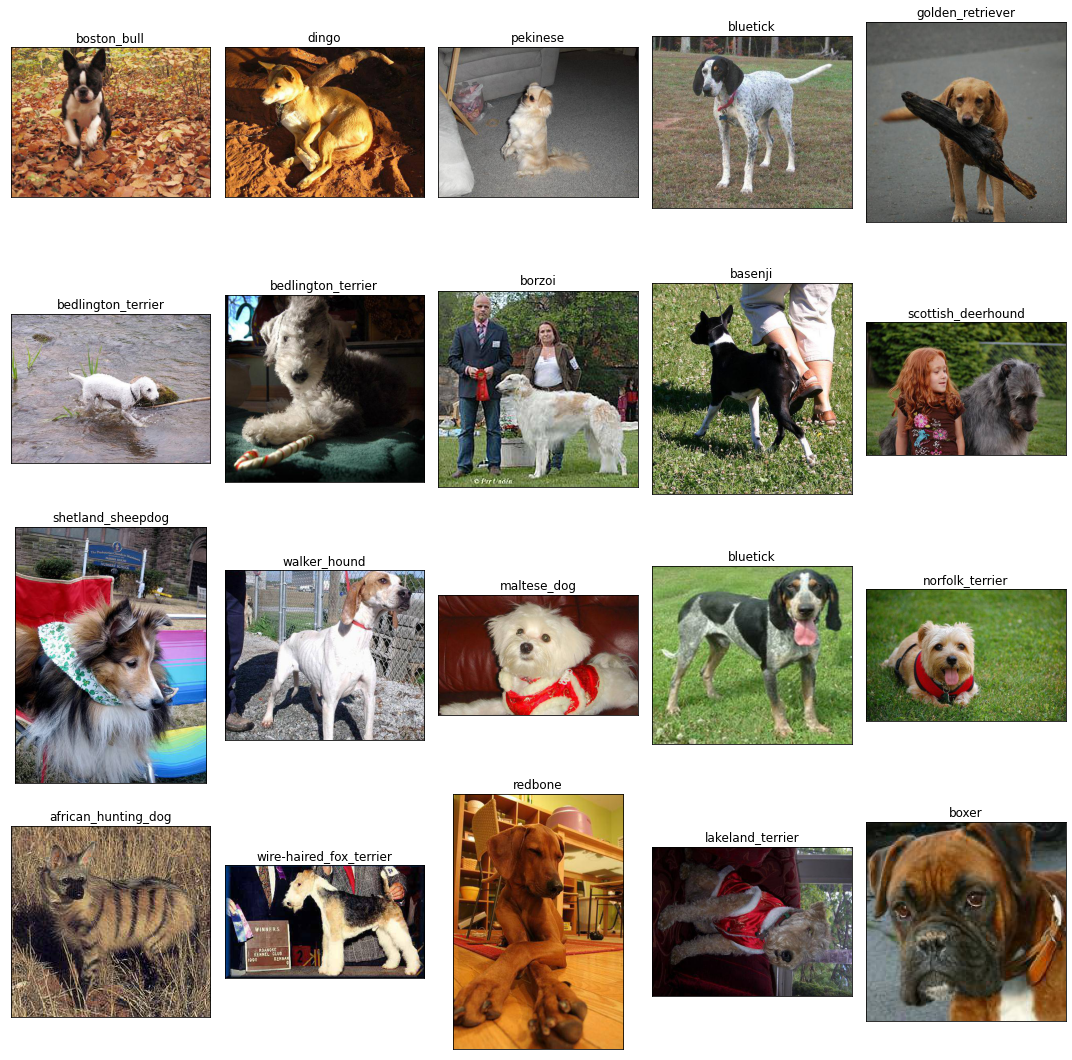

In [14]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data_df.path_img[i]))
    ax.set_title(data_df.breed[i])
plt.tight_layout()
plt.show()

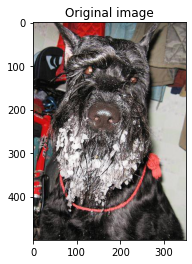

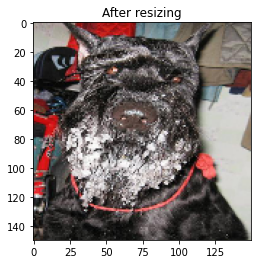

In [15]:
random_img=randint(0,len(data_df.path_img))
img_path=data_df.path_img[random_img]
img= plt.imread(img_path)

plt.imshow(img)
plt.title("Original image")
plt.show()

plt.imshow(cv2.resize(img, (150,150)))
plt.title("After resizing")
plt.show()

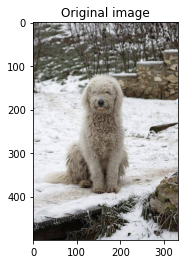

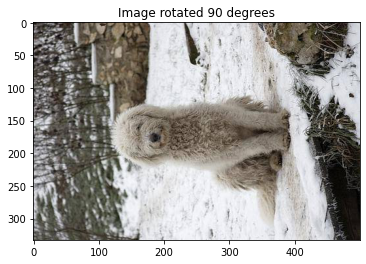

In [16]:
random_img=randint(0,len(data_df.path_img))
img_path=data_df.path_img[random_img]
img= plt.imread(img_path)

plt.imshow(img)
plt.title("Original image")
plt.show()


#rotation angle in degree

rotated1 = ndimage.rotate(img, 90)
plt.imshow(rotated1)
plt.title("Image rotated 90 degrees")
plt.show()

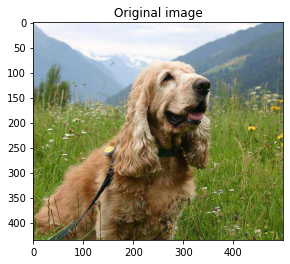

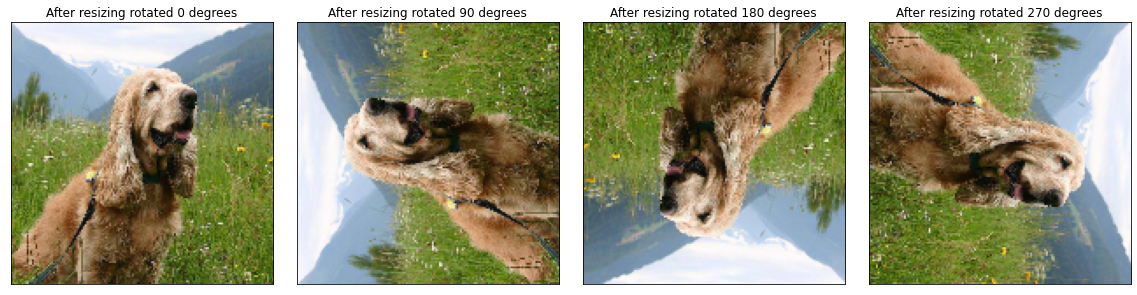

In [17]:
random_img=randint(0,len(data_df.path_img))
img_path=data_df.path_img[random_img]
img= plt.imread(img_path)

plt.imshow(img)
plt.title("Original image")
plt.show()


img=cv2.resize(img, (150,150))
turn =90

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(ndimage.rotate(img, i*90))
    ax.set_title("After resizing rotated "+ str(i*90) +" degrees")
plt.tight_layout()
plt.show()

In [18]:
class DogDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['id'], row['lbl']
        img_fname = self.root_dir + "/" + str(img_id) + ".jpg"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, img_label

In [19]:
class img_dataset(Dataset):
    def __init__(self,dataframe,transform=None,test=False):
        self.dataframe = dataframe
        self.transform = transform
        self.test = test
        
    def __getitem__(self,index):
        image_path = self.dataframe.iloc[index,3]
        assert os.path.exists(image_path), f"Expected image path: {image_path} to exist :("
        x = Image.open(image_path)
        if self.transform:
            x = self.transform(x)
        if self.test:
            return x
        else:
            y = self.dataframe.iloc[index,2]
            return x,y
        
    def __len__(self):
        return self.dataframe.shape[0]

In [20]:
train_transformer = transforms.Compose([transforms.RandomResizedCrop(224),
                                        transforms.RandomRotation(15),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
val_transformer = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [21]:
data_ds = DogDataset(data_df, TRAIN_DIR, transform=train_transformer)

In [22]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', labels[target])

Labels: scotch_terrier


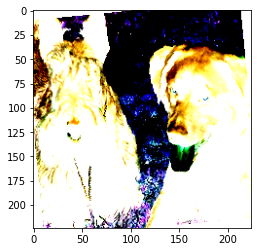

In [23]:
show_sample(*data_ds[2011])

In [24]:
def print_epoch_result(train_loss,train_acc,val_loss,val_acc):
    print('loss: {:.3f}, acc: {:.3f}, val_loss: {:.3f}, val_acc: {:.3f}'.format(train_loss,
                                                                              train_acc,
                                                                              val_loss,
                                                                              val_acc))
# Main Training function
def train_model(model, cost_function, optimizer,num_epochs):
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    
    # Metrics object
    train_acc_object = torchmetrics.Accuracy(compute_on_step=False)
    val_acc_object = torchmetrics.Accuracy(compute_on_step=False)
    
    for epoch in range(num_epochs):
        """
        On epoch start
        """
        print('-'*15)
        print('Start training {}/{}'.format(epoch+1, num_epochs))
        print('-'*15)
        
        # Training
        train_sub_losses = []
        model.train()
        for x,y in train_loader:
            optimizer.zero_grad()
            print(y)
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            loss = cost_function(y_hat,y)
            loss.backward()
            optimizer.step()
            #lr_scheduler.step()
            # update loss sublist
            train_sub_losses.append(loss.item())
            # update accuracy object
            train_acc_object(y_hat.cpu(),y.cpu())
            
        # Validation
        val_sub_losses = []
        model.eval()
        for x,y in val_loader:
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            loss = cost_function(y_hat,y)
            val_sub_losses.append(loss.item())
            val_acc_object(y_hat.cpu(),y.cpu())
            
        """
        On epoch end
        """
        # Update the loss list
        train_losses.append(np.mean(train_sub_losses))
        val_losses.append(np.mean(val_sub_losses))
        
        # Update the accuracy list and reset the metrics object 
        train_epoch_acc = train_acc_object.compute()
        val_epoch_acc = val_acc_object.compute()
        train_acc.append(train_epoch_acc)
        val_acc.append(val_epoch_acc)
        train_acc_object.reset()
        val_acc_object.reset()
        
        # print the result of epoch
        print_epoch_result(np.mean(train_sub_losses),train_epoch_acc,np.mean(val_sub_losses),val_epoch_acc)
        
    print('Finish Training.')
    return train_losses, train_acc, val_losses, val_acc

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

In [26]:
training_samples = data_df.shape[0] # Use small number first to test whether the model is doing well, then change back to full dataset
test_size=0.1
batch_size = 64

# Reduce the number of samples
sample_df = data_df.sample(training_samples)

# Split the comp_df into training set and validation set
x_train,x_val,_,_ = train_test_split(sample_df,sample_df,test_size=test_size)

# Create dataloaders form datasets
train_set = img_dataset(x_train, transform=train_transformer)
val_set = img_dataset(x_val, transform=val_transformer)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set , batch_size=batch_size, shuffle=True)

# How many images in training set and val set?
print('Training set: {}, Validation set: {}'.format(x_train.shape[0],x_val.shape[0]))

Training set: 9199, Validation set: 1023


In [27]:
class net(torch.nn.Module):
    def __init__(self, base_model, base_out_features, num_classes):
        super(net,self).__init__()
        self.base_model=base_model
        self.linear1 = torch.nn.Linear(base_out_features, 512)
        self.output = torch.nn.Linear(512,num_classes)
    def forward(self,x):
        x = F.relu(self.base_model(x))
        x = F.relu(self.linear1(x))
        x = self.output(x)
        return x

res = torchvision.models.resnet101(pretrained=True)
for param in res.parameters():
    param.requires_grad=False

model_final = net(base_model=res, base_out_features=res.fc.out_features, num_classes=120)
model_final = model_final.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [28]:
cost_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([param for param in model_final.parameters() if param.requires_grad], lr=0.00003)

# Learning rate scheduler
torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

# Epoch 
EPOCHS = 50

In [29]:
train_losses, train_acc, val_losses, val_acc = train_model(model=model_final, 
                                                           cost_function=cost_function, 
                                                           optimizer=optimizer,
                                                           num_epochs=EPOCHS)

Streaming output truncated to the last 5000 lines.
         26,  65,  68,  97,  44,  55,  63, 103,   0,  52,  92,  29,  95,  71,
         92,  59,  76,  18,  16,   6,  77,  48,  72,  71, 117,   5,  39,  15,
         59,  74,   2,   3,  19,  74,  92,  32])
tensor([ 84,   0,  17,  75, 115,  38,  14,  15,  68,  98,  80,  84,  71, 110,
          2,  70,  49,  76,  86,  83, 119,  94,  37,  87,   4,  45,  44,  56,
         95,  88,  65,  69,  71,  13,  77,  95,   4,  40,  80,  22, 119, 119,
         56,  59,  72,  97,  10,  66,  17,  64,  43, 100,  14, 100,  92,   6,
         73,  26,  61, 102, 105,  31,  33,  58])
tensor([ 26,  69,  35,  53, 101,  89,  86,  66,  62, 107,  83,  33, 105,  82,
         47, 118,   5,   8,  54, 101,  81,  10,  26,  83,  18,  60, 100,  71,
         68, 103,  76,  15, 102, 104,  62,  17,   1,  94,  99,  70,  86,  82,
         68,  79,   2,  57,  48,  20,  74,  62,  21,   7, 110,  88,  85,  30,
         29,   3,  72,  84,  22,  33,  76,  30])
tensor([ 70, 109, 119,

KeyboardInterrupt: ignored